In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

###### predict date range ######
# pd.date_range(start="2021-12-26",end="2022-01-01")
# pd.date_range(start="2022-01-23",end="2022-01-29")

In [23]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
  X = []
  y = []
  start = start + window
  if end is None:
    end = len(dataset) - horizon
  for i in range(start, end):
    indices = range(i-window, i)
    X.append(dataset[indices])
    indicey = range(i+1, i+1+horizon)
    y.append(target[indicey])
  return np.array(X), np.array(y) 

In [24]:
f1 = pd.concat([pd.read_csv('../Data/ground_temp_train.csv'), pd.read_csv('../Data/ground_temp_test.csv')])
f2 = pd.concat([pd.read_csv('../Data/sunrise_sunset_train.csv'), pd.read_csv('../Data/sunrise_sunset_test.csv')])

f1['년도'] = pd.to_datetime(f1['일시']).apply(lambda x: x.year)
f1['월'] = pd.to_datetime(f1['일시']).apply(lambda x: x.month)
f1['일'] = pd.to_datetime(f1['일시']).apply(lambda x: x.day)
f1['시'] = pd.to_datetime(f1['일시']).apply(lambda x: x.hour)

f1.drop(columns=['일시'],inplace=True)

f2['Unnamed: 0'] = f2['Unnamed: 0'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
f2['년도'] = pd.to_datetime(f2['Unnamed: 0']).apply(lambda x: x.year)
f2['월'] = pd.to_datetime(f2['Unnamed: 0']).apply(lambda x: x.month)
f2['일'] = pd.to_datetime(f2['Unnamed: 0']).apply(lambda x: x.day)

f2.drop(columns=['Unnamed: 0'],inplace=True)

In [25]:
df0 = pd.read_csv('../Data/smart_farm_final.csv')

test_idx = 129448
valid_idx = 89936

df0['열공급량(kWh)'] = df0['열공급량(kWh)'] * 1000

# f1 merge
df0 = pd.merge(df0,f1, on=['년도','월','일','시'], how='left')
# f2 merge
df0 = pd.merge(df0,f2, on=['년도','월','일'], how='left')

df0.set_index('시간',inplace=True)
df0.drop(columns=['년월일', '년도', '월', '일', '시', '분'],inplace=True)
df0.head()

,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),에너지스크린(수직),배기팬,천창,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh),누적강수량,현지기압,해면기압,일조,PM10_1시간,PM25_1시간,오존_1시간,이산화질소_1시간,일산화탄소_1시간,아황산가스_1시간,차광스크린_개방,차광스크린_광도조절,차광스크린_개방조절,차열스크린_온도조절,차열스크린_광도조절,차열스크린_개방조절,일출시간,일몰시간,일출3시간후,일출1시간후,일몰3시간후,일몰1시간반전,하루길이,시간범주,일몰전후,일출일몰,지면온도,오존등급,아황산가스등급,이산화질소등급,PM10등급,PM25등급,지면온도(°C),sunrise,sunset
시간,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-26 00:00:00,0.0,5.8,67,0.0,325,18.3,62.0,0,0,0,0,0,0,1,0.0,28,18.0,900.0,0.0,1018.2,1021.9,29180.0,33.0,22.0,0.003,0.028,0.4,0.003,0,1000미만,0%~30%개방,23도미만,800미만,0%~30%개방,713,1717,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통,2.7,713,1717
2021-11-26 00:01:00,0.0,5.8,67,0.4,344,18.1,63.4,0,0,0,0,0,0,1,0.0,28,18.0,900.0,0.0,1018.2,1021.9,0.0,33.0,22.0,0.003,0.028,0.4,0.003,0,1000미만,0%~30%개방,23도미만,800미만,0%~30%개방,713,1717,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통,2.7,713,1717
2021-11-26 00:02:00,0.0,5.7,67,0.9,105,17.7,65.2,0,0,0,0,0,0,1,1.0,28,18.0,900.0,0.0,1018.1,1021.8,0.0,33.0,22.0,0.003,0.028,0.4,0.003,0,1000미만,0%~30%개방,23도미만,800미만,0%~30%개방,713,1717,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통,2.7,713,1717
2021-11-26 00:03:00,0.0,5.7,67,1.3,123,17.7,63.9,0,0,0,0,0,0,1,1.0,28,18.0,800.0,0.0,1018.1,1021.8,0.0,33.0,22.0,0.003,0.028,0.4,0.003,0,1000미만,0%~30%개방,23도미만,800미만,0%~30%개방,713,1717,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통,2.7,713,1717
2021-11-26 00:04:00,0.0,5.7,67,0.9,123,17.6,64.7,0,0,0,0,0,0,1,1.0,28,18.0,1000.0,0.0,1018.1,1021.8,0.0,33.0,22.0,0.003,0.028,0.4,0.003,0,1000미만,0%~30%개방,23도미만,800미만,0%~30%개방,713,1717,1013,813,2017,1547,1004,야간,일몰1시간반_후,일몰,2.7,좋음,좋음,좋음,보통,보통,2.7,713,1717


In [26]:
dummy_lst = ['차광스크린_광도조절', '차광스크린_개방조절', '차열스크린_온도조절', '차열스크린_광도조절', '차열스크린_개방조절','시간범주','일몰전후', '일출일몰', '오존등급', '아황산가스등급', '이산화질소등급', 'PM10등급','PM25등급']
dummy_lst.append('열공급량(kWh)')
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(df0.iloc[:,~df0.columns.isin(dummy_lst)]) 
Y_data = Y_scaler.fit_transform(df0[['열공급량(kWh)']])

dummy_lst = ['차광스크린_광도조절', '차광스크린_개방조절', '차열스크린_온도조절', '차열스크린_광도조절', '차열스크린_개방조절','시간범주','일몰전후', '일출일몰', '오존등급', '아황산가스등급', '이산화질소등급', 'PM10등급','PM25등급']

In [27]:
X_dummy = np.array(pd.get_dummies(df0[dummy_lst]))
X_data = np.concatenate((X_data,X_dummy),axis=1)

In [28]:
# As we are doing multiple-step forecasting, let’s allow the model to see past 48 hours of data and forecast the 10 hrs after data
# hist_window = 48 / horizon = 10

# row : min -> 분단위 예측~
hist_window = 60
horizon = 10
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, valid_idx, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, valid_idx, test_idx, hist_window, horizon) 


In [29]:
print("before train x data shape:",X_data.shape)
print("before train y data shape:",Y_data.shape)

before train x data shape: (148168, 73)
before train y data shape: (148168, 1)


In [30]:
print("transformed train x data shape:",x_train.shape) # (data length, hist_window, n_features)
print("transformed train y data shape:",y_train.shape) # (data length, horizon, n_features)

transformed train x data shape: (89876, 60, 73)
transformed train y data shape: (89876, 10, 1)


In [31]:
print("transformed vali x data shape:",x_vali.shape) # (data length, hist_window, n_features)
print("transformed vali y data shape:",y_vali.shape) # (data length, horizon, n_features)

transformed vali x data shape: (39452, 60, 73)
transformed vali y data shape: (39452, 10, 1)


In [32]:
batch_size = 64
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [33]:
lstm_model = tf.keras.models.Sequential([
    LSTM(200, return_sequences=True, input_shape=x_train.shape[-2:]),
    Dense(128, activation='tanh'),
    LSTM(200),
    Dropout(0.5),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dropout(0.5),
    Dense(units=horizon),
])
lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
lstm_model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 200)           219200    
                                                                 
 dense_4 (Dense)             (None, 60, 128)           25728     
                                                                 
 lstm_3 (LSTM)               (None, 200)               263200    
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               25728     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [34]:
model_path = 'LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_rmse', min_delta=0, patience=25, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_rmse', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
history = lstm_model.fit(train_data,epochs=100,steps_per_epoch=100,validation_data=val_data,validation_steps=20,verbose=1,callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 9s 75ms/step - loss: 0.2041 - rmse: 0.4518 - val_loss: 0.0087 - val_rmse: 0.0932
Epoch 2/100
100/100 [==============================] - 7s 71ms/step - loss: 0.0185 - rmse: 0.1362 - val_loss: 0.0102 - val_rmse: 0.1010
Epoch 3/100
100/100 [==============================] - 7s 70ms/step - loss: 0.0120 - rmse: 0.1094 - val_loss: 0.0124 - val_rmse: 0.1113
Epoch 4/100
100/100 [==============================] - 7s 71ms/step - loss: 0.0068 - rmse: 0.0824 - val_loss: 0.0085 - val_rmse: 0.0921
Epoch 5/100
100/100 [==============================] - 7s 71ms/step - loss: 0.0084 - rmse: 0.0916 - val_loss: 0.0137 - val_rmse: 0.1169
Epoch 6/100
100/100 [==============================] - 7s 71ms/step - loss: 0.0069 - rmse: 0.0832 - val_loss: 0.0108 - val_rmse: 0.1037
Epoch 7/100
100/100 [==============================] - 7s 71ms/step - loss: 0.0059 - rmse: 0.0771 - val_loss: 0.0102 - val_rmse: 0.1011
Epoch 8/100
100/100 [===========================

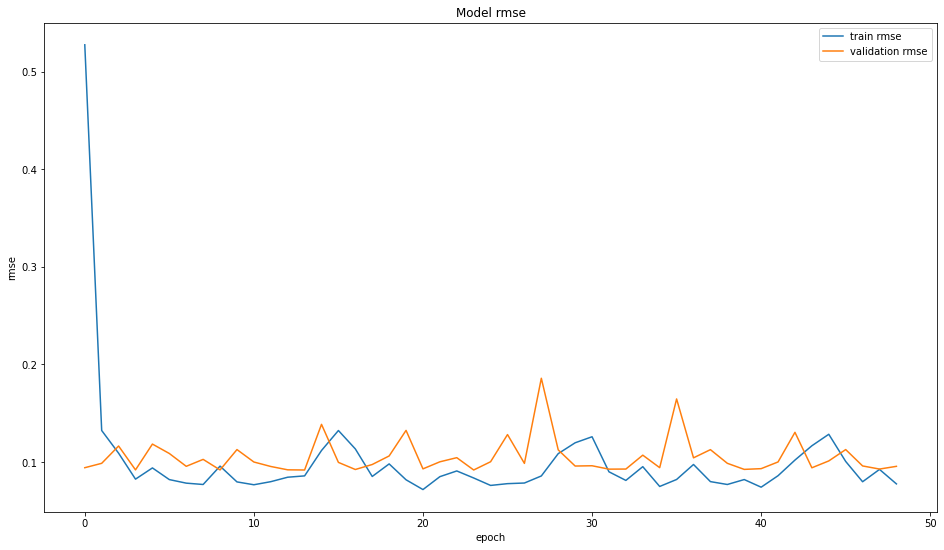

In [14]:
plt.figure(figsize=(16,9))
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train rmse', 'validation rmse'])
plt.show()

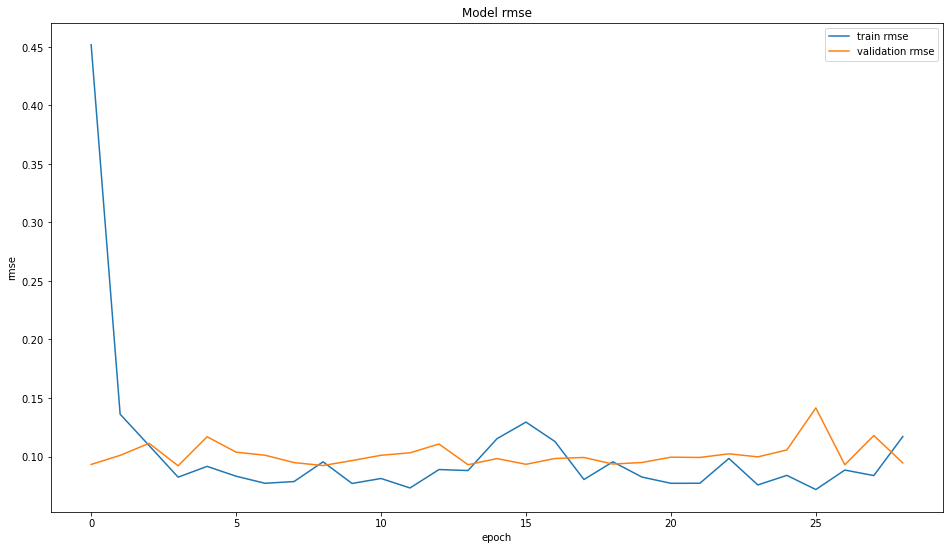

In [35]:
plt.figure(figsize=(16,9))
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train rmse', 'validation rmse'])
plt.show()

In [6]:
model = tf.keras.models.load_model("LSTM_Multivariate.h5")